In [1]:
import pyrealsense2 as rs
import open3d as o3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import cv2
from scipy.spatial.transform import Rotation as R
import copy
from IPython.display import clear_output
import time
from tqdm.notebook import tqdm

np.set_printoptions(precision=4, suppress=True)

# Saving all frames 

In [2]:
# data filenames
d435_filename = '../data/D435.bag'
t265_filename = '../data/T265.bag'

### T265 (extract key frames, every 220th frame)

In [3]:
# Setup:
cfg = rs.config()
cfg.enable_device_from_file(t265_filename)
cfg.enable_stream(rs.stream.pose)
pipe = rs.pipeline()
profile = pipe.start(cfg)

t265_data_list = []
t265_time_list = []
first_timestamp = None
count = 0
while(True):

    frames = pipe.wait_for_frames()
    pose = frames.get_pose_frame()
    
    if pose:
        if pose.get_timestamp() == first_timestamp:
            print('reached the first frame - reading bag file completed')
            break
        if first_timestamp is None:
            first_timestamp = pose.get_timestamp()
            print('first_timestamp',first_timestamp)
            t265_data_list.append(pose.get_pose_data())
            t265_time_list.append(pose.get_timestamp())
#         print('current-first',pose.get_timestamp()-first_timestamp)
#         t265_data_list.append(pose.get_pose_data())
#         t265_time_list.append(pose.get_timestamp())

        count+=1
        if count%220==0:
            print('current-first',pose.get_timestamp()-first_timestamp)
            t265_data_list.append(pose.get_pose_data())
            t265_time_list.append(pose.get_timestamp())
            
        
pipe.stop()

first_timestamp 1585059273040.0645
current-first 1104.82275390625
current-first 2214.822021484375
current-first 3339.490966796875
current-first 4459.2626953125
current-first 5559.16259765625
current-first 6658.993896484375
current-first 7758.8310546875
current-first 8858.709716796875
current-first 9958.537109375
current-first 11058.377685546875
current-first 12158.216064453125
current-first 13258.021728515625
current-first 14362.9228515625
current-first 15462.728271484375
current-first 16562.5849609375
current-first 17662.377685546875
current-first 18762.232177734375
current-first 19862.0361328125
current-first 20961.930419921875
current-first 22061.73388671875
current-first 23161.629638671875
current-first 24261.3984375
current-first 25361.192626953125
current-first 26461.14453125
current-first 27561.001220703125
current-first 28660.74462890625
current-first 29760.653564453125
reached the first frame - reading bag file completed


In [4]:
len(t265_time_list)

28

In [5]:
number_of_key_frames = len(t265_time_list)

### Extract transformations from 265 and plot them in 265 init frame

In [50]:
def get_transformation(data):
#     data = pose.get_pose_data()
    data_rot = [float(i.strip('xyzw: ')) for i in str(data.rotation).split(', ')]
    r = R.from_quat(data_rot)
    rotation = np.array(r.as_dcm())
    translation = np.array([float(i.strip('xyzw: ')) for i in str(data.translation).split(', ')])[np.newaxis].T
    T = np.hstack((rotation, translation))
    T = np.vstack((T, np.array([0, 0, 0, 1])))
    return T

In [7]:
def plot_pose(frames=[], poses=[], show_t=True, show_coord=True, show_pose=True, t_names=['$\mathbf{t}$']):
    """Plotting poses in frames

    Args:
        frames (list): frames to plot in addition to original frame.
        poses (list): poses to plot in the original frame.
        
        show_t (bool): depict t-vector name
        show_coord (bool): depict pose coordinates

    Returns:
        None.
    """
    def get_xyzuvctt(T):
        t = T[:3, 3:4].flatten(); t_ = t/(np.linalg.norm(t)+1e-5)*5
        R = T[:3,:3]
        (x, y, z), (u, v, c) = np.repeat(t.reshape(3,1),3, axis=1), R
        return x, y, z, u, v, c, t, t_
 
    
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111, projection='3d')
    lngth = 3

    # fig appearance
    ax.view_init(elev=22, azim=32)
    #ax.set_aspect('equal')
    ax.view_init(elev=22, azim=20)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.axis('off'); #ax.axis('equal')
    
    
    #origin and coordinate axes (coordinate frame)
    xl = 'x'; yl = 'y'; zl = 'z'; ol = 'O'
    x, y, z, u, v, c, t, t_ = get_xyzuvctt(np.eye(4))
        
    ax.scatter(t_[0], t_[1], t_[2], s=80, c='k')
    ax.quiver(x, y, z, u, v, c, color='k', length=lngth, arrow_length_ratio=0.2, linewidth=0.5)
    ax.text(0,-0.5,-0.1,ol); 
    ax.text(lngth*1.2,0,0,xl); ax.text(0,lngth*1.2,0,yl); ax.text(0,0,lngth*1.2,zl)
    # aid to have initial minimum dimensions of plot
    ax.scatter(4,4,4, alpha=0)
    
    for frame in frames:
        x, y, z, u, v, c, t, t_ = get_xyzuvctt(frame)
        ax.scatter(t_[0], t_[1], t_[2], s=80, c='k')
        ax.quiver(
            x, y, z, u, v, c, color='k', length=lngth, arrow_length_ratio=0.2, linewidth=0.5)
        xl += '\''; yl += '\''; zl += '\''; ol += '\''
        ax.text(t_[0],t_[1]-0.5,t_[2]-0.1,ol); 
        frame = frame @ np.diag([lngth*1.2, lngth*1.2, lngth*1.2, 1])
        ax.text(frame[:3,:3][0][0]+t_[0],frame[:3,:3][1][0]+t_[1], frame[:3,:3][2][0]+t_[2],xl);
        ax.text(frame[:3,:3][0][1]+t_[0],frame[:3,:3][1][1]+t_[1], frame[:3,:3][2][1]+t_[2],yl);
        ax.text(frame[:3,:3][0][2]+t_[0],frame[:3,:3][1][2]+t_[1], frame[:3,:3][2][2]+t_[2],zl);
    
    prev_t = [0, 0, 0]
    for i, pose in enumerate(poses):
        # given frame
        x, y, z, u, v, c, t, t_ = get_xyzuvctt(pose)
        ax.plot([prev_t[0], t[0]], [prev_t[1], t[1]], [prev_t[2], t[2]], color='k', linewidth=2)
        prev_t = t
  
    if show_pose:
            ax.quiver(x, y, z, u, v, c, arrow_length_ratio=0, color=['r','g','b'], linestyle='-', linewidth=4)
    if show_coord:
            ax.text(t[0], t[1], t[2]-0.7, '('+str(t[0])+','+str(t[1])+','+str(t[2])+')')
    
    plt.show()
#     fig.savefig('Path.png')

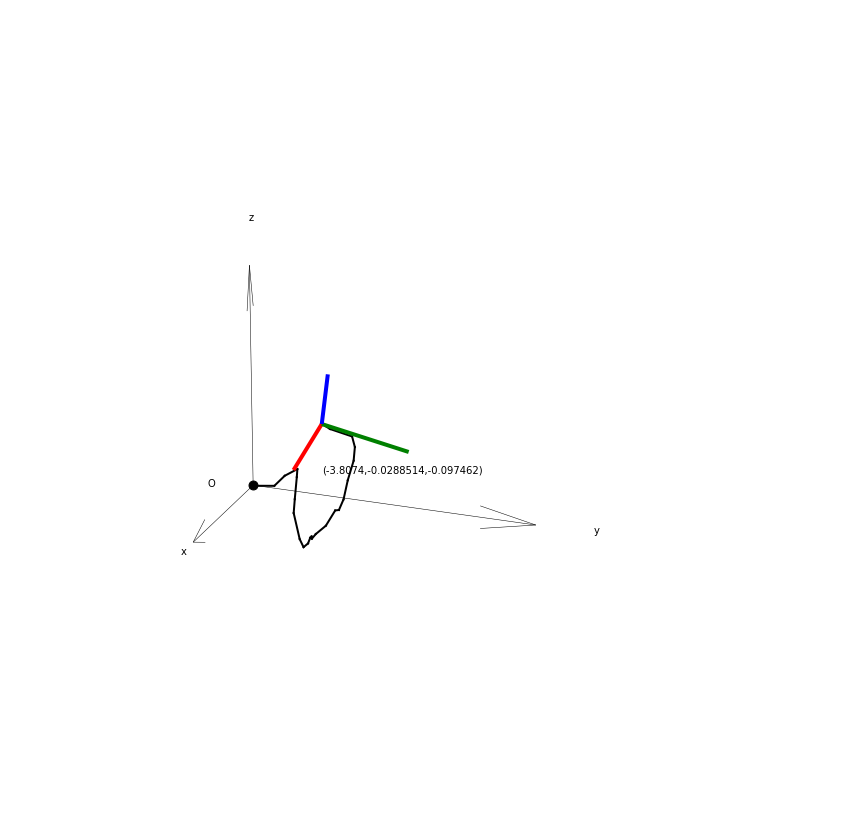

In [8]:
transformation_matrix_set = []
for pose in t265_data_list:
    transformation_matrix_set.append(get_transformation(pose))
    plot_pose(poses=transformation_matrix_set)
    time.sleep(0.01)
    clear_output(wait=True)
plt.show()

### D435i iterate over all frames

In [9]:
# Setup:
cfg = rs.config()
cfg.enable_device_from_file(d435_filename)
cfg.enable_stream(rs.stream.depth, 848, 480, rs.format.z16, 30)
pipe = rs.pipeline()
profile = pipe.start(cfg)

d435_data_list_all = []
d435_time_list_all = []
# a = np.array([])
# l = []
first_timestamp = None
counter = 0
while(True):

    frames = pipe.wait_for_frames()
    depth_frame = frames.get_depth_frame()
#     print('\ndepth_frame.get_timestamp()',depth_frame.get_timestamp())
    
    if depth_frame.get_timestamp() == first_timestamp:
        print('reached the first frame - reading bag file completed')
        print('timestamp',depth_frame.get_timestamp())
        break
    if first_timestamp is None:
        first_timestamp = depth_frame.get_timestamp()
        print('first_timestamp',first_timestamp)
    print('current-first',depth_frame.get_timestamp()-first_timestamp)
    
    d435_data_list_all.append(np.asanyarray(depth_frame.get_data()).copy())
    d435_time_list_all.append(depth_frame.get_timestamp())

cv2.destroyAllWindows()
pipe.stop()

first_timestamp 1585059272738.613
current-first 0.0
current-first 32.364013671875
current-first 65.6904296875
current-first 98.64453125
current-first 131.9052734375
current-first 165.260009765625
current-first 198.619384765625
current-first 231.972412109375
current-first 265.320556640625
current-first 298.669921875
current-first 332.087646484375
current-first 365.589111328125
current-first 398.846923828125
current-first 432.1474609375
current-first 465.772216796875
current-first 498.96435546875
current-first 532.234375
current-first 565.82763671875
current-first 598.99462890625
current-first 632.35302734375
current-first 665.62646484375
current-first 698.97509765625
current-first 732.40380859375
current-first 765.72802734375
current-first 799.047119140625
current-first 832.42724609375
current-first 865.82275390625
current-first 899.141357421875
current-first 932.950927734375
current-first 966.539306640625
current-first 999.246826171875
current-first 1032.65673828125
current-first 1065.

current-first 8804.00048828125
current-first 8837.44384765625
current-first 8870.922607421875
current-first 8904.041259765625
current-first 8937.414794921875
current-first 8970.74365234375
current-first 9004.131103515625
current-first 9037.5234375
current-first 9070.91943359375
current-first 9104.188720703125
current-first 9137.487548828125
current-first 9170.879638671875
current-first 9204.4130859375
current-first 9237.685546875
current-first 9270.93994140625
current-first 9304.329833984375
current-first 9337.723388671875
current-first 9371.021240234375
current-first 9404.494873046875
current-first 9437.6923828125
current-first 9471.15478515625
current-first 9504.37451171875
current-first 9537.784423828125
current-first 9571.24609375
current-first 9604.480224609375
current-first 9637.7802734375
current-first 9671.228515625
current-first 9704.627197265625
current-first 9737.8681640625
current-first 9771.18310546875
current-first 9804.661376953125
current-first 9838.06982421875
current-

current-first 17375.962158203125
current-first 17409.46923828125
current-first 17442.633544921875
current-first 17475.99267578125
current-first 17509.42919921875
current-first 17542.854248046875
current-first 17576.237548828125
current-first 17609.589111328125
current-first 17643.459716796875
current-first 17676.140380859375
current-first 17709.812744140625
current-first 17742.8505859375
current-first 17776.23046875
current-first 17809.529052734375
current-first 17843.444091796875
current-first 17877.308837890625
current-first 17909.65869140625
current-first 17942.952880859375
current-first 17976.346923828125
current-first 18009.655029296875
current-first 18043.059326171875
current-first 18076.3701171875
current-first 18109.759765625
current-first 18143.07958984375
current-first 18176.479736328125
current-first 18209.75830078125
current-first 18243.130126953125
current-first 18276.477294921875
current-first 18309.884765625
current-first 18343.191162109375
current-first 18376.5869140625

current-first 25948.182373046875
current-first 25981.568359375
current-first 26015.043212890625
current-first 26048.1474609375
current-first 26081.478515625
current-first 26114.8271484375
current-first 26147.88671875
current-first 26181.25830078125
current-first 26214.66259765625
current-first 26248.129638671875
current-first 26281.368896484375
current-first 26314.759033203125
current-first 26348.10595703125
current-first 26381.679931640625
current-first 26414.8466796875
current-first 26448.45458984375
current-first 26482.20703125
current-first 26514.983154296875
current-first 26548.885498046875
current-first 26581.6240234375
current-first 26615.031982421875
current-first 26648.266845703125
current-first 26681.665771484375
current-first 26714.9208984375
current-first 26748.472412109375
current-first 26781.6201171875
current-first 26815.01953125
current-first 26848.358642578125
current-first 26881.80029296875
current-first 26915.2099609375
current-first 26948.531005859375
current-first 

In [10]:
# find the correspondedces between t265_time_list and d435_time_list
d435_data_list = []
d435_time_list = []

for t265timestamp in t265_time_list:
    idx, val = min(enumerate(d435_time_list_all), key=lambda x: abs(x[1]-t265timestamp))
    d435_data_list.append(d435_data_list_all[idx])
    d435_time_list.append(d435_time_list_all[idx])

In [11]:
# just to check
i=27
t265_time_list[i], d435_time_list[i]

(1585059302800.718, 1585059302788.9272)

In [12]:
len(d435_time_list)

28

### Save key frames from 435

In [13]:
# Setup:
cfg = rs.config()
cfg.enable_device_from_file(d435_filename)
cfg.enable_stream(rs.stream.depth, 848, 480, rs.format.z16, 30)
pipe = rs.pipeline()
profile = pipe.start(cfg)

# d435_data_list_all = []
# d435_time_list_all = []
depth_frame_list = []
# a = np.array([])
# l = []
first_timestamp = None
counter = 0
while(True):

    frames = pipe.wait_for_frames()
    depth_frame = frames.get_depth_frame()
#     print('\ndepth_frame.get_timestamp()',depth_frame.get_timestamp())
    
    if depth_frame.get_timestamp() == first_timestamp:
        print('reached the first frame - reading bag file completed')
        print('timestamp',depth_frame.get_timestamp())
        break
    if first_timestamp is None:
        first_timestamp = depth_frame.get_timestamp()
        print('first_timestamp',first_timestamp)
#     print('current-first',depth_frame.get_timestamp()-first_timestamp)
    
    for d435timestamp in d435_time_list:
        if depth_frame.get_timestamp() == d435timestamp:
            depth_frame_list.append(depth_frame)
            print('current-first',depth_frame.get_timestamp()-first_timestamp)
    
    
#     d435_data_list_all.append(np.asanyarray(depth_frame.get_data()).copy())
#     d435_time_list_all.append(depth_frame.get_timestamp())

cv2.destroyAllWindows()
pipe.stop()

first_timestamp 1585059272738.613
current-first 298.669921875
current-first 1399.471923828125
current-first 2500.16064453125
current-first 3635.17138671875
current-first 4768.376953125
current-first 5868.853759765625
current-first 6969.515625
current-first 8070.408203125
current-first 9170.879638671875
current-first 10271.5986328125
current-first 11372.389404296875
current-first 12472.918212890625
current-first 13573.767333984375
current-first 14674.262939453125
current-first 15775.95556640625
current-first 16875.61279296875
current-first 17976.346923828125
current-first 19077.19580078125
current-first 20178.359130859375
current-first 21278.921875
current-first 22379.490478515625
current-first 23446.9248046875
current-first 24547.215087890625
current-first 25648.177978515625
current-first 26748.472412109375
current-first 27849.44384765625
current-first 28949.715087890625
current-first 30050.314208984375
reached the first frame - reading bag file completed
timestamp 1585059272738.613


In [14]:
len(depth_frame_list)

28

# Transformations

transformation between cameras

$ {}^{T}T_D$ - d435 wrt t265, always the same

In [15]:
T_d_wrt_t = np.array([[0.999968402, -0.006753626, -0.004188075, -0.015890727],
                      [-0.006685408, -0.999848172, 0.016093893, 0.028273059],
                      [-0.004296131, -0.016065384, -0.999861654, -0.009375589],
                      [0, 0, 0, 1]])

In [16]:
def get_transformation(data):
#     data = pose.get_pose_data()
    data_rot = [float(i.strip('xyzw: ')) for i in str(data.rotation).split(', ')]
    r = R.from_quat(data_rot)
    rotation = np.array(r.as_matrix())
    translation = np.array([float(i.strip('xyzw: ')) for i in str(data.translation).split(', ')])[np.newaxis].T
    T = np.hstack((rotation, translation))
    T = np.vstack((T, np.array([0, 0, 0, 1])))
    return T

In [17]:
relative_transformation_matrix_set = [] # based on 265 = T10,T21,T32, ...
for i in range(len(transformation_matrix_set)-1):
    T_t1_wrt_w = transformation_matrix_set[i]
    T_t2_wrt_w = transformation_matrix_set[i+1]
    T_d1_wrt_w = T_t1_wrt_w @ T_d_wrt_t
    T_d2_wrt_w = T_t2_wrt_w @ T_d_wrt_t
    T_d2_wrt_d1 = np.linalg.inv(T_d1_wrt_w) @ T_d2_wrt_w
    relative_transformation_matrix_set.append(T_d2_wrt_d1)

In [18]:
len(relative_transformation_matrix_set), len(transformation_matrix_set)

(27, 28)

# Point clouds registration

In [19]:
def get_geom_pcl(depth_frame): #slower
    pc = rs.pointcloud()
    points = pc.calculate(depth_frame).as_points()
    coordinates = np.ndarray(buffer=points.get_vertices(), dtype=np.float32, shape=(480, 848, 3)) \
        .reshape((-1, 3))
#     coordinates = coordinates[coordinates[:, 2] != 0]
    coordinates[coordinates[:, 2] > 1.5] = 0
    coordinates[coordinates[:, 2] < 0.5] = 0
    coordinates = coordinates[coordinates[:, 2] != 0]
    
    pcl = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(coordinates))
    return pcl

In [20]:
def get_geom_pcl(orig_depth_frame, koef_sampling=None):
        """
         TODO
        :param make_sampling:
        :return:
        """
        pc = rs.pointcloud()
        if koef_sampling is None:
            points = pc.calculate(orig_depth_frame).as_points()
        else:
            decimate = rs.decimation_filter()
            decimate.set_option(rs.option.filter_magnitude, koef_sampling)
            depth_frame = decimate.process(orig_depth_frame)

            points = pc.calculate(depth_frame).as_points()

        coordinates = np.ndarray(buffer=points.get_vertices(), dtype=np.float32, shape=(points.size(), 3))
        coordinates = coordinates[coordinates[:, 2] != 0]

#         coordinates = self.apply_transformation(self.tm_T265toD435, coordinates)
        pcl = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(coordinates))
        return pcl

In [21]:
SAMPLING_K = 2 ** 1

In [29]:
start_time = time.time()
icp_relative_transformation_matrix_set=[]
max_point_pair_dist = 0.05
mean_fitness = 0
mean_rmse = 0
for i in range(len(depth_frame_list)-1):
    pcl1 = get_geom_pcl(depth_frame_list[i], SAMPLING_K)
    pcl2 = get_geom_pcl(depth_frame_list[i+1], SAMPLING_K)
    init = relative_transformation_matrix_set[i]
    T = o3d.registration.registration_icp(pcl2, pcl1, max_point_pair_dist, init)
    print(i, T)
    icp_relative_transformation_matrix_set.append(T.transformation)
    mean_fitness += T.fitness
    mean_rmse += T.inlier_rmse
end_time = time.time()
print('--------------------------------------')
print('Execution time:', end_time - start_time, 's')
print('Mean fitness: {}, \t mean rmse: {}.'.format(
    np.round(mean_fitness / (i + 1), 3), mean_rmse / (i + 1)))

0 registration::RegistrationResult with fitness=9.747128e-01, inlier_rmse=1.220852e-02, and correspondence_set size of 90274
Access transformation to get result.
1 registration::RegistrationResult with fitness=8.295206e-01, inlier_rmse=1.811754e-02, and correspondence_set size of 79556
Access transformation to get result.
2 registration::RegistrationResult with fitness=8.280903e-01, inlier_rmse=1.677259e-02, and correspondence_set size of 77997
Access transformation to get result.
3 registration::RegistrationResult with fitness=6.112729e-01, inlier_rmse=1.563169e-02, and correspondence_set size of 59821
Access transformation to get result.
4 registration::RegistrationResult with fitness=7.348586e-01, inlier_rmse=1.473327e-02, and correspondence_set size of 71817
Access transformation to get result.
5 registration::RegistrationResult with fitness=8.043680e-01, inlier_rmse=1.039283e-02, and correspondence_set size of 77821
Access transformation to get result.
6 registration::Registration

In [31]:
times = []
rmses = []
fitnesses = []
for max_p_dist in [0.05, 0.1, 0.5, 1, 2, 5]:
    start_time = time.time()
    mean_fitness = 0
    mean_rmse = 0
    for i in tqdm(range(len(depth_frame_list)-1)):
        pcl1 = get_geom_pcl(depth_frame_list[i], SAMPLING_K)
        pcl2 = get_geom_pcl(depth_frame_list[i+1], SAMPLING_K)
        init = relative_transformation_matrix_set[i]
        T = o3d.registration.registration_icp(pcl2, pcl1, max_p_dist, init)
        mean_fitness += T.fitness
        mean_rmse += T.inlier_rmse
    end_time = time.time()
    print('--------------------------------------')
    print('max_pair_dist =', max_p_dist)
    print('Execution time:', end_time - start_time, 's')
    print('Mean fitness: {}, \t mean rmse: {}.'.format(
        np.round(mean_fitness / (i + 1), 3), mean_rmse / (i + 1)))
    times.append(end_time - start_time)
    rmses.append(mean_rmse / (i + 1))
    fitnesses.append(mean_fitness / (i + 1))


--------------------------------------
max_pair_dist = 0.05
Execution time: 72.12880039215088 s
Mean fitness: 0.797, 	 mean rmse: 0.01471817880444857.



--------------------------------------
max_pair_dist = 0.1
Execution time: 91.53003549575806 s
Mean fitness: 0.873, 	 mean rmse: 0.025081780798861957.



--------------------------------------
max_pair_dist = 0.5
Execution time: 153.40772581100464 s
Mean fitness: 0.994, 	 mean rmse: 0.062024679210780066.



--------------------------------------
max_pair_dist = 1
Execution time: 153.00747919082642 s
Mean fitness: 0.998, 	 mean rmse: 0.07103083897964403.



--------------------------------------
max_pair_dist = 2
Execution time: 148.86062955856323 s
Mean fitness: 0.999, 	 mean rmse: 0.07774774627072238.



--------------------------------------
max_pair_dist = 5
Execution time: 157.14295291900635 s
Mean fitness: 0.999, 	 mean rmse: 0.08944548862366362.


In [41]:
times_ones = []
rmses_ones = []
fitnesses_ones = []
for max_p_dist in [0.05, 0.1, 0.5, 1, 2, 5]:
    start_time = time.time()
    mean_fitness = 0
    mean_rmse = 0
    for i in tqdm(range(len(depth_frame_list)-1)):
        pcl1 = get_geom_pcl(depth_frame_list[i], SAMPLING_K)
        pcl2 = get_geom_pcl(depth_frame_list[i+1], SAMPLING_K)
        T = o3d.registration.registration_icp(pcl2, pcl1, max_p_dist)
        mean_fitness += T.fitness
        mean_rmse += T.inlier_rmse
    end_time = time.time()
    print('--------------------------------------')
    print('max_pair_dist =', max_p_dist)
    print('Execution time:', end_time - start_time, 's')
    print('Mean fitness: {}, \t mean rmse: {}.'.format(
        np.round(mean_fitness / (i + 1), 3), mean_rmse / (i + 1)))
    times_ones.append(end_time - start_time)
    rmses_ones.append(mean_rmse / (i + 1))
    fitnesses_ones.append(mean_fitness / (i + 1))


--------------------------------------
max_pair_dist = 0.05
Execution time: 107.778484582901 s
Mean fitness: 0.634, 	 mean rmse: 0.020380351801934263.



--------------------------------------
max_pair_dist = 0.1
Execution time: 150.21001553535461 s
Mean fitness: 0.84, 	 mean rmse: 0.03357394630641405.



--------------------------------------
max_pair_dist = 0.5
Execution time: 220.04681253433228 s
Mean fitness: 0.995, 	 mean rmse: 0.06522201166892871.



--------------------------------------
max_pair_dist = 1
Execution time: 233.1913983821869 s
Mean fitness: 0.998, 	 mean rmse: 0.07346067751612964.



--------------------------------------
max_pair_dist = 2
Execution time: 236.25555443763733 s
Mean fitness: 0.999, 	 mean rmse: 0.08064305499463542.



--------------------------------------
max_pair_dist = 5
Execution time: 231.41315007209778 s
Mean fitness: 0.999, 	 mean rmse: 0.09189219894501771.


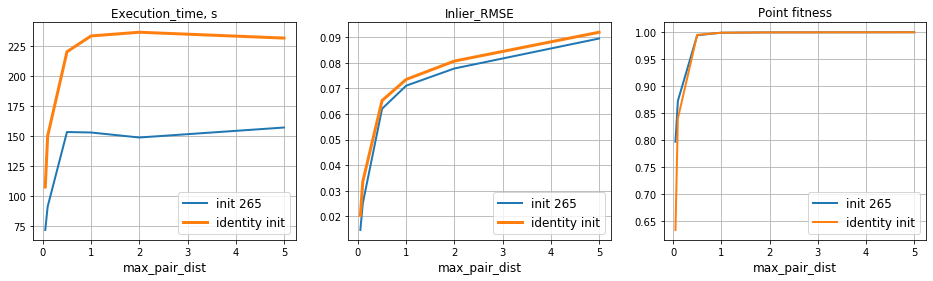

In [44]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
ax1.plot([0.05, 0.1, 0.5, 1, 2, 5], times, lw=2, label='init 265')
ax1.plot([0.05, 0.1, 0.5, 1, 2, 5], times_ones, lw=3, label='identity init')
ax1.set_title('Execution_time, s', fontsize=12)
ax1.set_xlabel('max_pair_dist', fontsize=12)
# ax1.set_ylabel('time, s', fontsize=12)
ax1.legend(fontsize=12)
ax1.grid()

ax2.plot([0.05, 0.1, 0.5, 1, 2, 5], rmses, lw=2, label='init 265')
ax2.plot([0.05, 0.1, 0.5, 1, 2, 5], rmses_ones, lw=3, label='identity init')
ax2.set_title('Inlier_RMSE', fontsize=12)
ax2.set_xlabel('max_pair_dist', fontsize=12)
ax2.legend(fontsize=12)
ax2.grid()
# ax2.set_ylabel('rmse', fontsize=12)

ax3.plot([0.05, 0.1, 0.5, 1, 2, 5], fitnesses, lw=2, label='init 265')
ax3.plot([0.05, 0.1, 0.5, 1, 2, 5], fitnesses_ones, lw=2, label='identity init')
ax3.set_title('Point fitness', fontsize=12)
ax3.set_xlabel('max_pair_dist', fontsize=12)
ax3.legend(fontsize=12)
ax3.grid()
# ax3.set_ylabel('fitness', fontsize=12)

# plt.show()
# plt.savefig('max_pair_dist_depend.png')
plt.savefig('max_pair_dist_depend.eps')

In [102]:
max_point_pair_dist = 0.05
times = []
rmses = []
fitnesses = []
icp_transformation_matrices_set = []
for k in [None, 1, 2, 3]:
    if k is None:
        SAMPLING_K = None
    else:
        SAMPLING_K = 2 ** k
        
    start_time = time.time()
    mean_fitness = 0
    mean_rmse = 0
    
    tr_mcs = []
    
    for i in tqdm(range(len(depth_frame_list)-1)):
        pcl1 = get_geom_pcl(depth_frame_list[i], SAMPLING_K)
        pcl2 = get_geom_pcl(depth_frame_list[i+1], SAMPLING_K)
        init = relative_transformation_matrix_set[i]
        T = o3d.registration.registration_icp(pcl2, pcl1, max_point_pair_dist, init)
        tr_mcs.append(T.transformation)
        mean_fitness += T.fitness
        mean_rmse += T.inlier_rmse
    end_time = time.time()
    
    print('--------------------------------------')
    print('sampling coef =', SAMPLING_K)
    print('Execution time:', end_time - start_time, 's')
    print('Mean fitness: {}, \t mean rmse: {}.'.format(
        np.round(mean_fitness / (i + 1), 3), mean_rmse / (i + 1)))
    
    times.append(end_time - start_time)
    rmses.append(mean_rmse / (i + 1))
    fitnesses.append(mean_fitness / (i + 1))
    
    icp_transformation_matrices_set.append(tr_mcs)


--------------------------------------
sampling coef = None
Execution time: 335.8176522254944 s
Mean fitness: 0.802, 	 mean rmse: 0.014194122698468583.



--------------------------------------
sampling coef = 2
Execution time: 60.59787392616272 s
Mean fitness: 0.798, 	 mean rmse: 0.01478290148161239.



--------------------------------------
sampling coef = 4
Execution time: 14.059391736984253 s
Mean fitness: 0.789, 	 mean rmse: 0.016183154135971104.



--------------------------------------
sampling coef = 8
Execution time: 3.4916598796844482 s
Mean fitness: 0.766, 	 mean rmse: 0.019258481453788005.


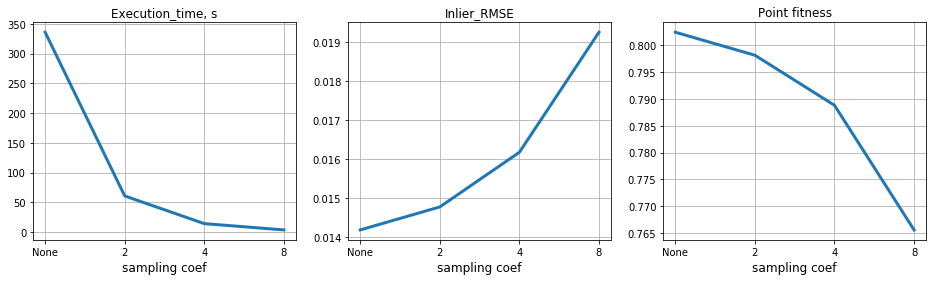

In [103]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
ax1.plot(['None', '2', '4', '8'], times, lw=3)
# ax1.plot([0.05, 0.1, 0.5, 1, 2, 5], times_ones, lw=3, label='identity init')
ax1.set_title('Execution_time, s', fontsize=12)
ax1.set_xlabel('sampling coef', fontsize=12)
# ax1.set_ylabel('time, s', fontsize=12)
# ax1.legend(fontsize=12)
ax1.grid()

ax2.plot(['None', '2', '4', '8'], rmses, lw=3)
# ax2.plot([0.05, 0.1, 0.5, 1, 2, 5], rmses_ones, lw=3, label='identity init')
ax2.set_title('Inlier_RMSE', fontsize=12)
ax2.set_xlabel('sampling coef', fontsize=12)
# ax2.legend(fontsize=12)
ax2.grid()
# ax2.set_ylabel('rmse', fontsize=12)

ax3.plot(['None', '2', '4', '8'], fitnesses, lw=3)
# ax3.plot([0.05, 0.1, 0.5, 1, 2, 5], fitnesses_ones, lw=2, label='identity init')
ax3.set_title('Point fitness', fontsize=12)
ax3.set_xlabel('sampling coef', fontsize=12)
# ax3.legend(fontsize=12)
ax3.grid()
# ax3.set_ylabel('fitness', fontsize=12)

# plt.show()
# plt.savefig('sampling_coef_depend.png')
plt.savefig('sampling_coef_depend.eps')

In [25]:
len(icp_transformation_matrices_set)

4

In [26]:
t265_traj = np.array([0,0,0])
icp_trajs = [np.array([0,0,0]) for _ in range(4)]
# icp_ones_traj = np.array([0,0,0])

# transformation_matrix_set = []
# icp_transformation_matrix_sets = [[], [], [], []]
# icp_transformation_matrix_set_ones = []

current_transformation_265 = np.eye(4)
current_transformation_icp_set = [np.eye(4) for _ in range(4)]
# current_transformation_icp_ones = np.eye(4)

for i in range(len(relative_transformation_matrix_set)):
    current_transformation_265 = current_transformation_265 @ relative_transformation_matrix_set[i]
#     transformation_matrix_set.append(current_transformation_265)
    t265_traj = np.hstack((t265_traj, current_transformation_265[:3,-1]))

    for k in range(4):
        current_transformation_icp_set[k] = current_transformation_icp_set[k] @ \
                                            icp_transformation_matrices_set[k][i]
#         icp_transformation_matrix_sets[k].append(current_transformation_icp_set[k])
    
#     current_transformation_icp_ones = current_transformation_icp @ icp_relative_transformation_matrix_set_ones[i]
#     icp_transformation_matrix_set_ones.append(current_transformation_icp_ones)
    
    
        icp_trajs[k] = np.hstack((icp_trajs[k], current_transformation_icp_set[k][:3,-1]))
#     icp_ones_traj = np.hstack((icp_ones_traj, current_transformation_icp_ones[:3,-1]))
    
t265_traj = t265_traj.reshape(-1,3)
icp_trajs = [icp_traj.reshape(-1,3) for icp_traj in icp_trajs]
# icp_ones_traj = icp_ones_traj.reshape(-1,3)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


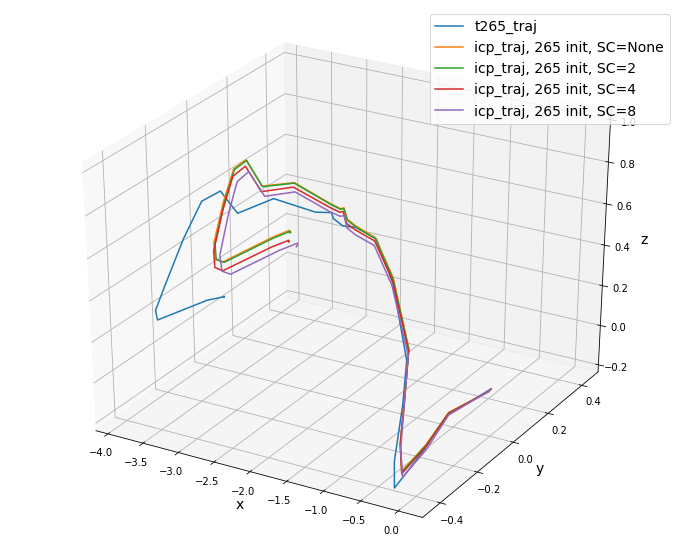

In [91]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot3D(t265_traj[:,0], t265_traj[:,1], t265_traj[:,2], label='t265_traj')
for k, name in enumerate(['None', '2', '4', '8']):
    ax.plot3D(icp_trajs[k][:,0], icp_trajs[k][:,1], icp_trajs[k][:,2], 
              label='icp_traj, 265 init, SC='+name)


ax.legend(fontsize=14)
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('y', fontsize=14)
ax.set_zlabel('z', fontsize=14)
fig.set_size_inches(12, 10)
# plt.savefig('SC_traj.png')
plt.savefig('SC_traj.eps')

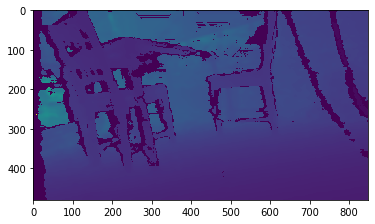

In [62]:
from IPython.display import clear_output

depth_frame_ims = [depth_frame.get_data() for depth_frame in depth_frame_list]

for d_f in depth_frame_ims:
    clear_output(wait=True)
    plt.imshow(d_f)
    plt.show()

In [63]:
len(depth_frame_list)

28

In [29]:
def count_diff_frames(frames):
    prev_frame = None
    for i, frame in enumerate(frames):
        if prev_frame is not None:
            print("Difference bw {0} and {1} frames is {2:.4f} ms".format(i, i-1, frame.get_timestamp()-prev_frame.get_timestamp()))
        prev_frame = frame

In [30]:
def get_diff_sensors(frames1, frames2):
    if len(frames1) != len(frames2):
        return
    else:
        for i in range(len(frames1)):
            print("Difference bw frames1[{0}] and frames2[{0}] frames is {1:.4f} ms".format(i, frames1[i].get_timestamp()-frames2[i].get_timestamp()))
        

### Difference between frames is 0.5 s.

In [31]:
# #for 2 sec
# count_of_frames = 16
# frames_between_frames_D435 = 60

#for 2 sec
count_of_frames = 60
frames_between_frames_D435 = 15

In [37]:
d435_filename = '../data/D435.bag'
t265_filename = '../data/T265.bag'

In [38]:
cfg_d435 = rs.config()
cfg_d435.enable_device_from_file(d435_filename)
cfg_d435.enable_stream(rs.stream.depth, 848, 480, rs.format.z16, 30)
pipe_d435 = rs.pipeline()
pipe_d435.start(cfg_d435)

cfg_t265 = rs.config()
cfg_t265.enable_device_from_file(t265_filename)
cfg_t265.enable_stream(rs.stream.pose)
pipe_t265 = rs.pipeline()
pipe_t265.start(cfg_t265)

In [39]:
d435_frames_timestamps = []
while len(d435_frames_timestamps) != count_of_frames:
    for i in range(frames_between_frames_D435):
        depth_frame = pipe_d435.wait_for_frames().get_depth_frame()
    d435_frames_timestamps.append(depth_frame.get_timestamp())


In [40]:
d435_frames_timestamps = np.array(d435_frames_timestamps)
d435_frames_timestamps[1:]-d435_frames_timestamps[:-1]

array([500.4026, 500.2566, 500.2183, 500.394 , 500.3335, 501.2134,
       499.3232, 500.3188, 500.2759, 500.2705, 500.8376, 499.9993,
       500.1333, 500.4207, 500.5542, 500.0305, 500.1521, 500.2927,
       500.5205, 500.1724, 500.5474, 500.0249, 500.3003, 500.4956,
       500.175 , 500.2776, 500.3008, 500.2971, 500.3096, 500.3213,
       500.302 , 500.3408, 500.2881, 501.0061, 499.6199, 500.3071,
       500.7795, 500.1038, 500.4351, 499.9534, 500.9775, 499.6436,
       500.6553, 499.8452, 500.6121, 500.2371, 500.1882, 500.3433,
       500.2261, 500.7913, 499.7087, 500.3801, 500.9678, 499.6738,
       500.2446, 500.5918, 500.2012, 500.1699, 500.2307])

In [41]:
d435_frames_timestamps - d435_frames_timestamps[0]

array([    0.    ,   500.4026,  1000.6592,  1500.8774,  2001.2715,
        2501.605 ,  3002.8184,  3502.1416,  4002.4604,  4502.7363,
        5003.0068,  5503.8445,  6003.8438,  6503.9771,  7004.3977,
        7504.9519,  8004.9824,  8505.1345,  9005.4272,  9505.9478,
       10006.1201, 10506.6675, 11006.6924, 11506.9927, 12007.4883,
       12507.6633, 13007.9409, 13508.2417, 14008.5388, 14508.8484,
       15009.1697, 15509.4717, 16009.8125, 16510.1006, 17011.1067,
       17510.7266, 18011.0337, 18511.8132, 19011.917 , 19512.3521,
       20012.3054, 20513.283 , 21012.9265, 21513.5818, 22013.427 ,
       22514.0391, 23014.2761, 23514.4644, 24014.8076, 24515.0337,
       25015.825 , 25515.5337, 26015.9138, 26516.8816, 27016.5554,
       27516.8   , 28017.3918, 28517.593 , 29017.7629, 29517.9937])

In [42]:
d435_frames = []
times = []
while len(d435_frames) != count_of_frames:
    depth_frame = pipe_d435.wait_for_frames().get_depth_frame()
    t =  depth_frame.get_timestamp()
    if( t in d435_frames_timestamps) and (t not in times):
        d435_frames.append(depth_frame)
        times.append(depth_frame.get_timestamp())
    print(len(d435_frames))

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
26
26
26
2

In [43]:
d435_frames = np.array(d435_frames)
d435_frames = d435_frames[np.argsort(times)]

In [44]:
pose_frame = None
pose_frame_time = -1
thresh = 7
t265_frames = []
t265_frames_temp = []
n = 0

for i, depth_frame in enumerate(d435_frames):
    depth_frame_time = depth_frame.get_timestamp()
    while abs(depth_frame_time-pose_frame_time) > thresh:
        pose_frame = pipe_t265.wait_for_frames().get_pose_frame()
        pose_frame_time = pose_frame.get_timestamp()
    while abs(depth_frame_time-pose_frame_time) <= thresh:
        pose_frame = pipe_t265.wait_for_frames().get_pose_frame()
        t265_frames_temp.append(pose_frame)
        pose_frame_time = pose_frame.get_timestamp()

    min_int_index = 0
    min_interval = thresh * 2
    for ind_pose, temp_pose in enumerate(t265_frames_temp):
        if abs(depth_frame_time-temp_pose.get_timestamp())<min_interval:
            min_interval = abs(depth_frame_time-temp_pose.get_timestamp())
            min_int_index = ind_pose
    t265_frames.append(t265_frames_temp[min_int_index])
    print(len(t265_frames))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


In [45]:
count_diff_frames(d435_frames)

Difference bw 1 and 0 frames is 500.4026 ms
Difference bw 2 and 1 frames is 500.2566 ms
Difference bw 3 and 2 frames is 500.2183 ms
Difference bw 4 and 3 frames is 500.3940 ms
Difference bw 5 and 4 frames is 500.3335 ms
Difference bw 6 and 5 frames is 501.2134 ms
Difference bw 7 and 6 frames is 499.3232 ms
Difference bw 8 and 7 frames is 500.3188 ms
Difference bw 9 and 8 frames is 500.2759 ms
Difference bw 10 and 9 frames is 500.2705 ms
Difference bw 11 and 10 frames is 500.8376 ms
Difference bw 12 and 11 frames is 499.9993 ms
Difference bw 13 and 12 frames is 500.1333 ms
Difference bw 14 and 13 frames is 500.4207 ms
Difference bw 15 and 14 frames is 500.5542 ms
Difference bw 16 and 15 frames is 500.0305 ms
Difference bw 17 and 16 frames is 500.1521 ms
Difference bw 18 and 17 frames is 500.2927 ms
Difference bw 19 and 18 frames is 500.5205 ms
Difference bw 20 and 19 frames is 500.1724 ms
Difference bw 21 and 20 frames is 500.5474 ms
Difference bw 22 and 21 frames is 500.0249 ms
Differe

In [46]:
first = d435_frames[0].get_timestamp()
for frame in d435_frames:
    print(frame.get_timestamp() - first)

0.0
500.402587890625
1000.6591796875
1500.87744140625
2001.271484375
2501.60498046875
3002.818359375
3502.1416015625
4002.46044921875
4502.736328125
5003.0068359375
5503.844482421875
6003.84375
6503.97705078125
7004.397705078125
7504.951904296875
8004.982421875
8505.134521484375
9005.42724609375
9505.94775390625
10006.1201171875
10506.66748046875
11006.6923828125
11506.99267578125
12007.48828125
12507.663330078125
13007.94091796875
13508.24169921875
14008.538818359375
14508.848388671875
15009.169677734375
15509.4716796875
16009.8125
16510.1005859375
17011.106689453125
17510.7265625
18011.03369140625
18511.813232421875
19011.9169921875
19512.35205078125
20012.305419921875
20513.282958984375
21012.926513671875
21513.581787109375
22013.427001953125
22514.0390625
23014.276123046875
23514.46435546875
24014.8076171875
24515.03369140625
25015.824951171875
25515.53369140625
26015.913818359375
26516.881591796875
27016.555419921875
27516.800048828125
28017.391845703125
28517.593017578125
29017.7

In [47]:
count_diff_frames(t265_frames)

Difference bw 1 and 0 frames is 499.9272 ms
Difference bw 2 and 1 frames is 499.9124 ms
Difference bw 3 and 2 frames is 504.9570 ms
Difference bw 4 and 3 frames is 500.0591 ms
Difference bw 5 and 4 frames is 499.7988 ms
Difference bw 6 and 5 frames is 499.8901 ms
Difference bw 7 and 6 frames is 500.0623 ms
Difference bw 8 and 7 frames is 499.7295 ms
Difference bw 9 and 8 frames is 500.1316 ms
Difference bw 10 and 9 frames is 499.7905 ms
Difference bw 11 and 10 frames is 499.9136 ms
Difference bw 12 and 11 frames is 499.8921 ms
Difference bw 13 and 12 frames is 499.9553 ms
Difference bw 14 and 13 frames is 499.9348 ms
Difference bw 15 and 14 frames is 504.9177 ms
Difference bw 16 and 15 frames is 499.9209 ms
Difference bw 17 and 16 frames is 499.9736 ms
Difference bw 18 and 17 frames is 499.8521 ms
Difference bw 19 and 18 frames is 499.9910 ms
Difference bw 20 and 19 frames is 499.8508 ms
Difference bw 21 and 20 frames is 499.9568 ms
Difference bw 22 and 21 frames is 499.9702 ms
Differe

In [48]:
get_diff_sensors(d435_frames, t265_frames)

Difference bw frames1[0] and frames2[0] frames is 0.9553 ms
Difference bw frames1[1] and frames2[1] frames is 1.4307 ms
Difference bw frames1[2] and frames2[2] frames is 1.7749 ms
Difference bw frames1[3] and frames2[3] frames is -2.9639 ms
Difference bw frames1[4] and frames2[4] frames is -2.6289 ms
Difference bw frames1[5] and frames2[5] frames is -2.0942 ms
Difference bw frames1[6] and frames2[6] frames is -0.7710 ms
Difference bw frames1[7] and frames2[7] frames is -1.5100 ms
Difference bw frames1[8] and frames2[8] frames is -0.9207 ms
Difference bw frames1[9] and frames2[9] frames is -0.7764 ms
Difference bw frames1[10] and frames2[10] frames is -0.2964 ms
Difference bw frames1[11] and frames2[11] frames is 0.6277 ms
Difference bw frames1[12] and frames2[12] frames is 0.7349 ms
Difference bw frames1[13] and frames2[13] frames is 0.9128 ms
Difference bw frames1[14] and frames2[14] frames is 1.3987 ms
Difference bw frames1[15] and frames2[15] frames is -2.9648 ms
Difference bw frame

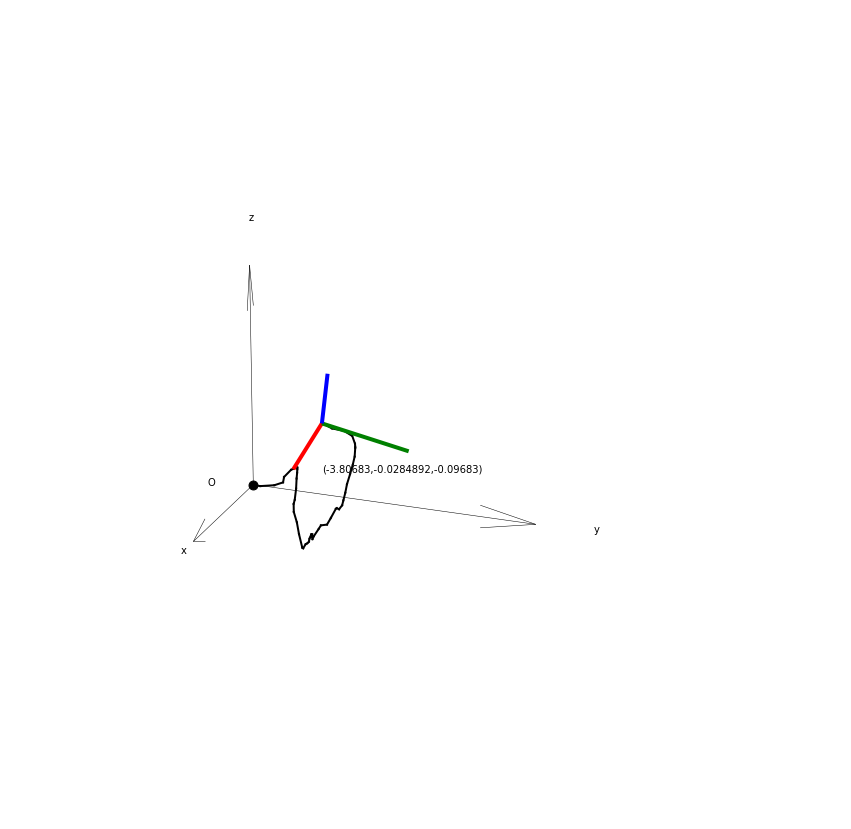

In [51]:
transformation_matrix_set_05 = []
for pose in t265_frames:
    transformation_matrix_set_05.append(get_transformation(pose.get_pose_data()))
    plot_pose(poses=transformation_matrix_set_05)
    time.sleep(0.01)
    clear_output(wait=True)
plt.show()

In [52]:
relative_transformation_matrix_set_05 = [] # based on 265 = T10,T21,T32, ...
for i in range(len(transformation_matrix_set_05)-1):
    T_t1_wrt_w = transformation_matrix_set_05[i]
    T_t2_wrt_w = transformation_matrix_set_05[i+1]
    T_d1_wrt_w = T_t1_wrt_w @ T_d_wrt_t
    T_d2_wrt_w = T_t2_wrt_w @ T_d_wrt_t
    T_d2_wrt_d1 = np.linalg.inv(T_d1_wrt_w) @ T_d2_wrt_w
    relative_transformation_matrix_set_05.append(T_d2_wrt_d1)

In [55]:
max_point_pair_dist = 0.05
# times_05 = []
# rmses_05 = []
# fitnesses_05 = []
# icp_transformation_matrices_set_05 = []
for k in [1, 2, 3]:
    if k is None:
        SAMPLING_K = None
    else:
        SAMPLING_K = 2 ** k
        
    start_time = time.time()
    mean_fitness = 0
    mean_rmse = 0
    
    tr_mcs = []
    
    for i in tqdm(range(len(d435_frames)-1)):
        pcl1 = get_geom_pcl(d435_frames[i], SAMPLING_K)
        pcl2 = get_geom_pcl(d435_frames[i+1], SAMPLING_K)
        init = relative_transformation_matrix_set_05[i]
        T = o3d.registration.registration_icp(pcl2, pcl1, max_point_pair_dist, init)
        tr_mcs.append(T.transformation)
        mean_fitness += T.fitness
        mean_rmse += T.inlier_rmse
    end_time = time.time()
    
    print('--------------------------------------')
    print('sampling coef =', SAMPLING_K)
    print('Execution time:', end_time - start_time, 's')
    print('Mean fitness: {}, \t mean rmse: {}.'.format(
        np.round(mean_fitness / (i + 1), 3), mean_rmse / (i + 1)))
    
    times_05.append(end_time - start_time)
    rmses_05.append(mean_rmse / (i + 1))
    fitnesses_05.append(mean_fitness / (i + 1))
    
    icp_transformation_matrices_set_05.append(tr_mcs)


--------------------------------------
sampling coef = 2
Execution time: 122.0981457233429 s
Mean fitness: 0.901, 	 mean rmse: 0.01299836369168594.



--------------------------------------
sampling coef = 4
Execution time: 26.233519554138184 s
Mean fitness: 0.893, 	 mean rmse: 0.014515484974797302.



--------------------------------------
sampling coef = 8
Execution time: 7.230851650238037 s
Mean fitness: 0.871, 	 mean rmse: 0.01775927620077423.


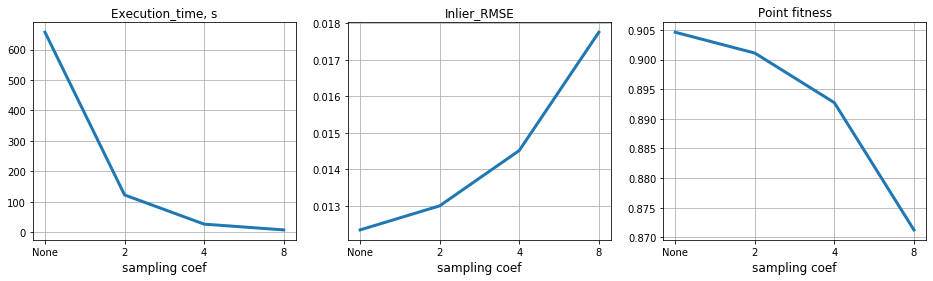

In [59]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
ax1.plot(['None', '2', '4', '8'], times_05, lw=3)
# ax1.plot([0.05, 0.1, 0.5, 1, 2, 5], times_ones, lw=3, label='identity init')
ax1.set_title('Execution_time, s', fontsize=12)
ax1.set_xlabel('sampling coef', fontsize=12)
# ax1.set_ylabel('time, s', fontsize=12)
# ax1.legend(fontsize=12)
ax1.grid()

ax2.plot(['None', '2', '4', '8'], rmses_05, lw=3)
# ax2.plot([0.05, 0.1, 0.5, 1, 2, 5], rmses_ones, lw=3, label='identity init')
ax2.set_title('Inlier_RMSE', fontsize=12)
ax2.set_xlabel('sampling coef', fontsize=12)
# ax2.legend(fontsize=12)
ax2.grid()
# ax2.set_ylabel('rmse', fontsize=12)

ax3.plot(['None', '2', '4', '8'], fitnesses_05, lw=3)
# ax3.plot([0.05, 0.1, 0.5, 1, 2, 5], fitnesses_ones, lw=2, label='identity init')
ax3.set_title('Point fitness', fontsize=12)
ax3.set_xlabel('sampling coef', fontsize=12)
# ax3.legend(fontsize=12)
ax3.grid()
# ax3.set_ylabel('fitness', fontsize=12)

# plt.show()
# plt.savefig('sampling_coef_depend_05.png')
plt.savefig('sampling_coef_depend_05.eps')

In [60]:
t265_traj_05 = np.array([0,0,0])
icp_trajs_05 = [np.array([0,0,0]) for _ in range(4)]

current_transformation_265 = np.eye(4)
current_transformation_icp_set = [np.eye(4) for _ in range(4)]
# current_transformation_icp_ones = np.eye(4)

for i in range(len(relative_transformation_matrix_set_05)):
    current_transformation_265 = current_transformation_265 @ relative_transformation_matrix_set_05[i]
#     transformation_matrix_set.append(current_transformation_265)
    t265_traj_05 = np.hstack((t265_traj_05, current_transformation_265[:3,-1]))

    for k in range(4):
        current_transformation_icp_set[k] = current_transformation_icp_set[k] @ \
                                            icp_transformation_matrices_set_05[k][i]
#         icp_transformation_matrix_sets[k].append(current_transformation_icp_set[k])
    
#     current_transformation_icp_ones = current_transformation_icp @ icp_relative_transformation_matrix_set_ones[i]
#     icp_transformation_matrix_set_ones.append(current_transformation_icp_ones)
    
    
        icp_trajs_05[k] = np.hstack((icp_trajs_05[k], current_transformation_icp_set[k][:3,-1]))
#     icp_ones_traj = np.hstack((icp_ones_traj, current_transformation_icp_ones[:3,-1]))
    
t265_traj_05 = t265_traj_05.reshape(-1,3)
icp_trajs_05 = [icp_traj.reshape(-1,3) for icp_traj in icp_trajs_05]
# icp_ones_traj = icp_ones_traj.reshape(-1,3)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


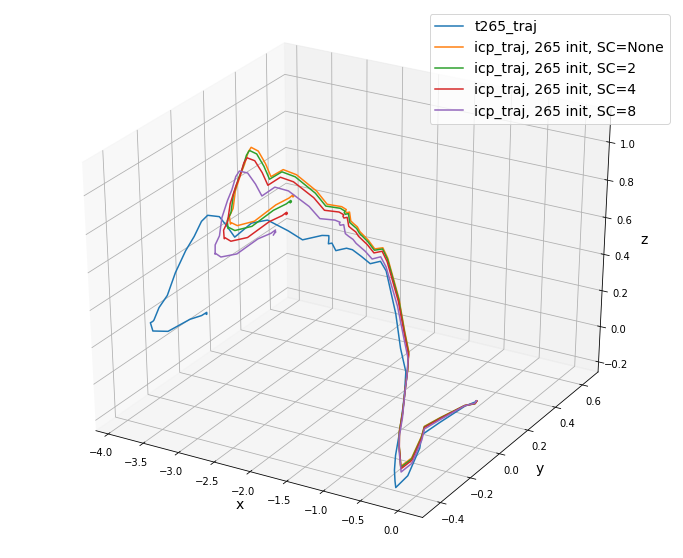

In [89]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot3D(t265_traj_05[:,0], t265_traj_05[:,1], t265_traj_05[:,2], label='t265_traj')
for k, name in enumerate(['None', '2', '4', '8']):
    ax.plot3D(icp_trajs_05[k][:,0], icp_trajs_05[k][:,1], icp_trajs_05[k][:,2], 
              label='icp_traj, 265 init, SC='+name)


ax.legend(fontsize=14)
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('y', fontsize=14)
ax.set_zlabel('z', fontsize=14)
fig.set_size_inches(12, 10)
# plt.savefig('SC_traj_05.png')
plt.savefig('SC_traj_05.eps')

### Difference between frames is 2 s.

In [63]:
# #for 2 sec
# count_of_frames = 16
# frames_between_frames_D435 = 60

#for 2 sec
count_of_frames = 15
frames_between_frames_D435 = 60

In [64]:
d435_filename = '../data/D435.bag'
t265_filename = '../data/T265.bag'

In [65]:
cfg_d435 = rs.config()
cfg_d435.enable_device_from_file(d435_filename)
cfg_d435.enable_stream(rs.stream.depth, 848, 480, rs.format.z16, 30)
pipe_d435 = rs.pipeline()
pipe_d435.start(cfg_d435)

cfg_t265 = rs.config()
cfg_t265.enable_device_from_file(t265_filename)
cfg_t265.enable_stream(rs.stream.pose)
pipe_t265 = rs.pipeline()
pipe_t265.start(cfg_t265)

In [66]:
d435_frames_timestamps = []
while len(d435_frames_timestamps) != count_of_frames:
    for i in range(frames_between_frames_D435):
        depth_frame = pipe_d435.wait_for_frames().get_depth_frame()
    d435_frames_timestamps.append(depth_frame.get_timestamp())


In [67]:
d435_frames_timestamps = np.array(d435_frames_timestamps)
d435_frames_timestamps[1:]-d435_frames_timestamps[:-1]

array([  2000.9441,   2001.3506,   2001.0586,   2001.3108,   2001.1545,
         2001.2478,   2001.3416,   2001.1064,   2001.4487,   2001.1992,
         2001.1482,   2001.1812,   2001.1978, -29050.9385])

In [68]:
d435_frames_timestamps - d435_frames_timestamps[0]

array([    0.    ,  2000.9441,  4002.2947,  6003.3533,  8004.6641,
       10005.8186, 12007.0664, 14008.408 , 16009.5144, 18010.9631,
       20012.1624, 22013.3105, 24014.4917, 26015.6895, -3035.249 ])

In [69]:
d435_frames = []
times = []
while len(d435_frames) != count_of_frames:
    depth_frame = pipe_d435.wait_for_frames().get_depth_frame()
    t =  depth_frame.get_timestamp()
    if( t in d435_frames_timestamps) and (t not in times):
        d435_frames.append(depth_frame)
        times.append(depth_frame.get_timestamp())
    print(len(d435_frames))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8


In [70]:
d435_frames = np.array(d435_frames)
d435_frames = d435_frames[np.argsort(times)]

In [71]:
pose_frame = None
pose_frame_time = -1
thresh = 7
t265_frames = []
t265_frames_temp = []
n = 0

for i, depth_frame in enumerate(d435_frames):
    depth_frame_time = depth_frame.get_timestamp()
    while abs(depth_frame_time-pose_frame_time) > thresh:
        pose_frame = pipe_t265.wait_for_frames().get_pose_frame()
        pose_frame_time = pose_frame.get_timestamp()
    while abs(depth_frame_time-pose_frame_time) <= thresh:
        pose_frame = pipe_t265.wait_for_frames().get_pose_frame()
        t265_frames_temp.append(pose_frame)
        pose_frame_time = pose_frame.get_timestamp()

    min_int_index = 0
    min_interval = thresh * 2
    for ind_pose, temp_pose in enumerate(t265_frames_temp):
        if abs(depth_frame_time-temp_pose.get_timestamp())<min_interval:
            min_interval = abs(depth_frame_time-temp_pose.get_timestamp())
            min_int_index = ind_pose
    t265_frames.append(t265_frames_temp[min_int_index])
    print(len(t265_frames))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [72]:
count_diff_frames(d435_frames)

Difference bw 1 and 0 frames is 3035.2490 ms
Difference bw 2 and 1 frames is 2000.9441 ms
Difference bw 3 and 2 frames is 2001.3506 ms
Difference bw 4 and 3 frames is 2001.0586 ms
Difference bw 5 and 4 frames is 2001.3108 ms
Difference bw 6 and 5 frames is 2001.1545 ms
Difference bw 7 and 6 frames is 2001.2478 ms
Difference bw 8 and 7 frames is 2001.3416 ms
Difference bw 9 and 8 frames is 2001.1064 ms
Difference bw 10 and 9 frames is 2001.4487 ms
Difference bw 11 and 10 frames is 2001.1992 ms
Difference bw 12 and 11 frames is 2001.1482 ms
Difference bw 13 and 12 frames is 2001.1812 ms
Difference bw 14 and 13 frames is 2001.1978 ms


In [73]:
first = d435_frames[0].get_timestamp()
for frame in d435_frames:
    print(frame.get_timestamp() - first)

0.0
3035.2490234375
5036.193115234375
7037.543701171875
9038.602294921875
11039.9130859375
13041.067626953125
15042.3154296875
17043.656982421875
19044.763427734375
21046.212158203125
23047.411376953125
25048.5595703125
27049.74072265625
29050.9384765625


In [74]:
count_diff_frames(t265_frames)

Difference bw 1 and 0 frames is 3034.5398 ms
Difference bw 2 and 1 frames is 1999.7136 ms
Difference bw 3 and 2 frames is 2004.6938 ms
Difference bw 4 and 3 frames is 1999.6665 ms
Difference bw 5 and 4 frames is 1999.7688 ms
Difference bw 6 and 5 frames is 2004.6741 ms
Difference bw 7 and 6 frames is 1999.7385 ms
Difference bw 8 and 7 frames is 1999.6985 ms
Difference bw 9 and 8 frames is 1999.6702 ms
Difference bw 10 and 9 frames is 2004.7915 ms
Difference bw 11 and 10 frames is 1999.6931 ms
Difference bw 12 and 11 frames is 1999.5940 ms
Difference bw 13 and 12 frames is 2004.7903 ms
Difference bw 14 and 13 frames is 1999.7417 ms


In [75]:
get_diff_sensors(d435_frames, t265_frames)

Difference bw frames1[0] and frames2[0] frames is -0.6523 ms
Difference bw frames1[1] and frames2[1] frames is 0.0569 ms
Difference bw frames1[2] and frames2[2] frames is 1.2874 ms
Difference bw frames1[3] and frames2[3] frames is -2.0559 ms
Difference bw frames1[4] and frames2[4] frames is -0.6638 ms
Difference bw frames1[5] and frames2[5] frames is 0.8782 ms
Difference bw frames1[6] and frames2[6] frames is -2.6414 ms
Difference bw frames1[7] and frames2[7] frames is -1.1321 ms
Difference bw frames1[8] and frames2[8] frames is 0.5110 ms
Difference bw frames1[9] and frames2[9] frames is 1.9473 ms
Difference bw frames1[10] and frames2[10] frames is -1.3955 ms
Difference bw frames1[11] and frames2[11] frames is 0.1106 ms
Difference bw frames1[12] and frames2[12] frames is 1.6648 ms
Difference bw frames1[13] and frames2[13] frames is -1.9443 ms
Difference bw frames1[14] and frames2[14] frames is -0.4883 ms


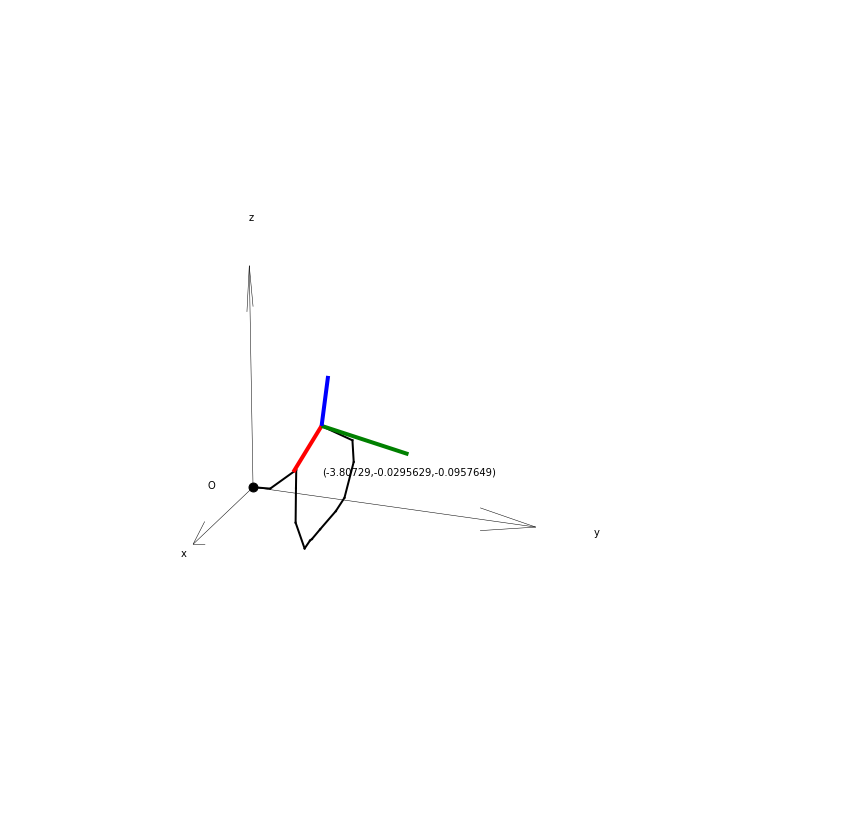

In [76]:
transformation_matrix_set_2 = []
for pose in t265_frames:
    transformation_matrix_set_2.append(get_transformation(pose.get_pose_data()))
    plot_pose(poses=transformation_matrix_set_2)
    time.sleep(0.01)
    clear_output(wait=True)
plt.show()

In [77]:
relative_transformation_matrix_set_2 = [] # based on 265 = T10,T21,T32, ...
for i in range(len(transformation_matrix_set_2)-1):
    T_t1_wrt_w = transformation_matrix_set_2[i]
    T_t2_wrt_w = transformation_matrix_set_2[i+1]
    T_d1_wrt_w = T_t1_wrt_w @ T_d_wrt_t
    T_d2_wrt_w = T_t2_wrt_w @ T_d_wrt_t
    T_d2_wrt_d1 = np.linalg.inv(T_d1_wrt_w) @ T_d2_wrt_w
    relative_transformation_matrix_set_2.append(T_d2_wrt_d1)

In [79]:
max_point_pair_dist = 0.05
times_2 = []
rmses_2 = []
fitnesses_2 = []
icp_transformation_matrices_set_2 = []
for k in [None, 1, 2, 3]:
    if k is None:
        SAMPLING_K = None
    else:
        SAMPLING_K = 2 ** k
        
    start_time = time.time()
    mean_fitness = 0
    mean_rmse = 0
    
    tr_mcs = []
    
    for i in tqdm(range(len(d435_frames)-1)):
        pcl1 = get_geom_pcl(d435_frames[i], SAMPLING_K)
        pcl2 = get_geom_pcl(d435_frames[i+1], SAMPLING_K)
        init = relative_transformation_matrix_set_2[i]
        T = o3d.registration.registration_icp(pcl2, pcl1, max_point_pair_dist, init)
        tr_mcs.append(T.transformation)
        mean_fitness += T.fitness
        mean_rmse += T.inlier_rmse
    end_time = time.time()
    
    print('--------------------------------------')
#     print('max_pair_dist =', max_p_dist)
    print('Execution time:', end_time - start_time, 's')
    print('Mean fitness: {}, \t mean rmse: {}.'.format(
        np.round(mean_fitness / (i + 1), 3), mean_rmse / (i + 1)))
    
    times_2.append(end_time - start_time)
    rmses_2.append(mean_rmse / (i + 1))
    fitnesses_2.append(mean_fitness / (i + 1))
    
    icp_transformation_matrices_set_2.append(tr_mcs)


--------------------------------------
Execution time: 165.96507120132446 s
Mean fitness: 0.671, 	 mean rmse: 0.015799913084622735.



--------------------------------------
Execution time: 32.684163093566895 s
Mean fitness: 0.667, 	 mean rmse: 0.016360245698567713.



--------------------------------------
Execution time: 7.4909820556640625 s
Mean fitness: 0.659, 	 mean rmse: 0.017752717219360375.



--------------------------------------
Execution time: 1.9848129749298096 s
Mean fitness: 0.636, 	 mean rmse: 0.020817644566845046.


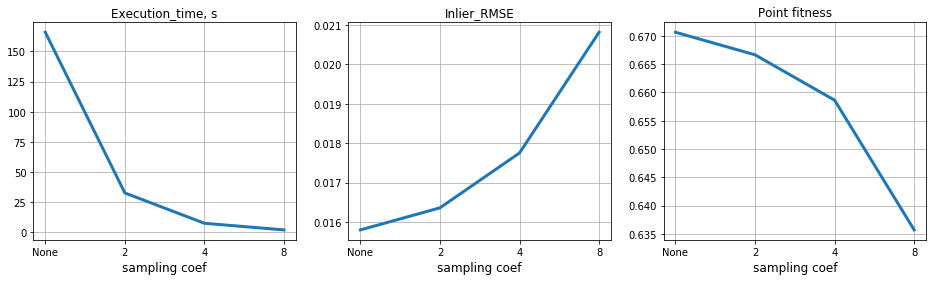

In [82]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
ax1.plot(['None', '2', '4', '8'], times_2, lw=3)
# ax1.plot([0.05, 0.1, 0.5, 1, 2, 5], times_ones, lw=3, label='identity init')
ax1.set_title('Execution_time, s', fontsize=12)
ax1.set_xlabel('sampling coef', fontsize=12)
# ax1.set_ylabel('time, s', fontsize=12)
# ax1.legend(fontsize=12)
ax1.grid()

ax2.plot(['None', '2', '4', '8'], rmses_2, lw=3)
# ax2.plot([0.05, 0.1, 0.5, 1, 2, 5], rmses_ones, lw=3, label='identity init')
ax2.set_title('Inlier_RMSE', fontsize=12)
ax2.set_xlabel('sampling coef', fontsize=12)
# ax2.legend(fontsize=12)
ax2.grid()
# ax2.set_ylabel('rmse', fontsize=12)

ax3.plot(['None', '2', '4', '8'], fitnesses_2, lw=3)
# ax3.plot([0.05, 0.1, 0.5, 1, 2, 5], fitnesses_ones, lw=2, label='identity init')
ax3.set_title('Point fitness', fontsize=12)
ax3.set_xlabel('sampling coef', fontsize=12)
# ax3.legend(fontsize=12)
ax3.grid()
# ax3.set_ylabel('fitness', fontsize=12)

# plt.show()
# plt.savefig('sampling_coef_depend_2.png')
plt.savefig('sampling_coef_depend_2.eps')

In [83]:
t265_traj_2 = np.array([0,0,0])
icp_trajs_2 = [np.array([0,0,0]) for _ in range(4)]

current_transformation_265 = np.eye(4)
current_transformation_icp_set = [np.eye(4) for _ in range(4)]
# current_transformation_icp_ones = np.eye(4)

for i in range(len(relative_transformation_matrix_set_2)):
    current_transformation_265 = current_transformation_265 @ relative_transformation_matrix_set_2[i]
#     transformation_matrix_set.append(current_transformation_265)
    t265_traj_2 = np.hstack((t265_traj_2, current_transformation_265[:3,-1]))

    for k in range(4):
        current_transformation_icp_set[k] = current_transformation_icp_set[k] @ \
                                            icp_transformation_matrices_set_2[k][i]
#         icp_transformation_matrix_sets[k].append(current_transformation_icp_set[k])
    
#     current_transformation_icp_ones = current_transformation_icp @ icp_relative_transformation_matrix_set_ones[i]
#     icp_transformation_matrix_set_ones.append(current_transformation_icp_ones)
    
    
        icp_trajs_2[k] = np.hstack((icp_trajs_2[k], current_transformation_icp_set[k][:3,-1]))
#     icp_ones_traj = np.hstack((icp_ones_traj, current_transformation_icp_ones[:3,-1]))
    
t265_traj_2 = t265_traj_2.reshape(-1,3)
icp_trajs_2 = [icp_traj.reshape(-1,3) for icp_traj in icp_trajs_2]
# icp_ones_traj = icp_ones_traj.reshape(-1,3)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


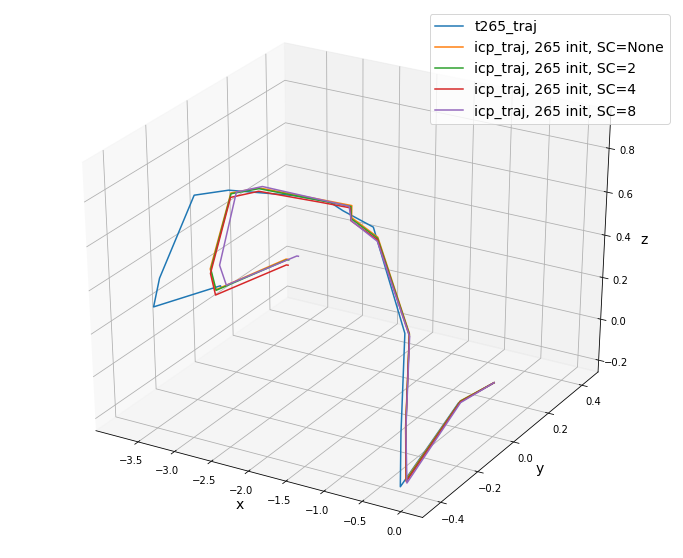

In [98]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot3D(t265_traj_2[:,0], t265_traj_2[:,1], t265_traj_2[:,2], label='t265_traj')
for k, name in enumerate(['None', '2', '4', '8']):
    ax.plot3D(icp_trajs_2[k][:,0], icp_trajs_2[k][:,1], icp_trajs_2[k][:,2], 
              label='icp_traj, 265 init, SC='+name)


ax.legend(fontsize=14)
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('y', fontsize=14)
ax.set_zlabel('z', fontsize=14)
fig.set_size_inches(12, 10)
# plt.savefig('SC_traj_2.png')
plt.savefig('SC_traj_2.eps')

### Comparison of 0.5 ms, 1s and 2s

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


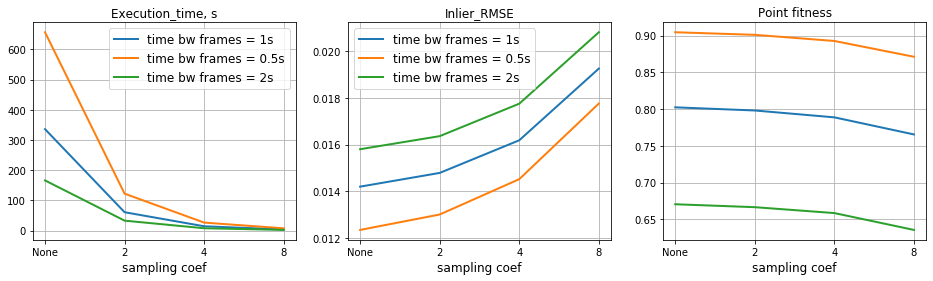

In [105]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
ax1.plot(['None', '2', '4', '8'], times, lw=2, label='time bw frames = 1s')
ax1.plot(['None', '2', '4', '8'], times_05, lw=2, label='time bw frames = 0.5s')
ax1.plot(['None', '2', '4', '8'], times_2, lw=2, label='time bw frames = 2s')
# ax1.plot([0.05, 0.1, 0.5, 1, 2, 5], times_ones, lw=3, label='identity init')
ax1.set_title('Execution_time, s', fontsize=12)
ax1.set_xlabel('sampling coef', fontsize=12)
# ax1.set_ylabel('time, s', fontsize=12)
ax1.legend(fontsize=12)
ax1.grid()

ax2.plot(['None', '2', '4', '8'], rmses, lw=2, label='time bw frames = 1s')
ax2.plot(['None', '2', '4', '8'], rmses_05, lw=2, label='time bw frames = 0.5s')
ax2.plot(['None', '2', '4', '8'], rmses_2, lw=2, label='time bw frames = 2s')
# ax2.plot([0.05, 0.1, 0.5, 1, 2, 5], rmses_ones, lw=3, label='identity init')
ax2.set_title('Inlier_RMSE', fontsize=12)
ax2.set_xlabel('sampling coef', fontsize=12)
ax2.legend(fontsize=12)
ax2.grid()
# ax2.set_ylabel('rmse', fontsize=12)

ax3.plot(['None', '2', '4', '8'], fitnesses, lw=2, label='time bw frames = 1s')
ax3.plot(['None', '2', '4', '8'], fitnesses_05, lw=2, label='time bw frames = 0.5s')
ax3.plot(['None', '2', '4', '8'], fitnesses_2, lw=2, label='time bw frames = 2s')
# ax3.plot([0.05, 0.1, 0.5, 1, 2, 5], fitnesses_ones, lw=2, label='identity init')
ax3.set_title('Point fitness', fontsize=12)
ax3.set_xlabel('sampling coef', fontsize=12)
# ax3.legend(fontsize=12)
ax3.grid()
# ax3.set_ylabel('fitness', fontsize=12)

# plt.show()
# plt.savefig('sampling_coef_depend.png')
plt.savefig('comparison_SC.eps')
# plt.savefig('comparison_SC.png')

In [94]:
times

[1585059286245.453,
 1585059288246.7007,
 1585059290248.0422,
 1585059292249.1487,
 1585059294250.5974,
 1585059296251.7966,
 1585059298252.9448,
 1585059300254.126,
 1585059302255.3237,
 1585059273204.3853,
 1585059276239.6343,
 1585059278240.5784,
 1585059280241.929,
 1585059282242.9875,
 1585059284244.2983]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


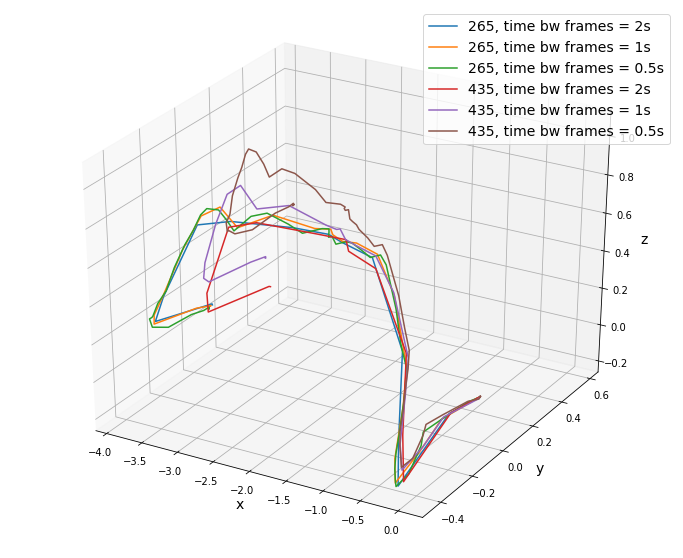

In [107]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot3D(t265_traj_2[:,0], t265_traj_2[:,1], t265_traj_2[:,2], label='265, time bw frames = 2s')
ax.plot3D(t265_traj[:,0], t265_traj[:,1], t265_traj[:,2], label='265, time bw frames = 1s')
ax.plot3D(t265_traj_05[:,0], t265_traj_05[:,1], t265_traj_05[:,2], label='265, time bw frames = 0.5s')
ax.plot3D(icp_trajs_2[2][:,0], icp_trajs_2[2][:,1], icp_trajs_2[2][:,2], label='435, time bw frames = 2s')
ax.plot3D(icp_trajs[2][:,0], icp_trajs[2][:,1], icp_trajs[2][:,2], label='435, time bw frames = 1s')
ax.plot3D(icp_trajs_05[2][:,0], icp_trajs_05[2][:,1], icp_trajs_05[2][:,2], label='435, time bw frames = 0.5s')
# for k, name in enumerate(['None', '2', '4', '8']):
#     ax.plot3D(icp_trajs_2[2][:,0], icp_trajs_2[2][:,1], icp_trajs_2[2][:,2], 
#               label='icp_traj, 265 init, SC=4'+name)


ax.legend(fontsize=14)
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('y', fontsize=14)
ax.set_zlabel('z', fontsize=14)
fig.set_size_inches(12, 10)
# plt.savefig('SC_traj_comparison.png')
plt.savefig('SC_traj_comparison.eps')